In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
# plt.style.use('clean.mplstyle')
import shap

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

## Load Model to Get Null (Additive Efficient Normalization)

In [3]:
#Select GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
### Load Model (For Efficiency Addative Normalization)
from tensorflow.keras.layers import (Input, Layer, Dense, Lambda, Reshape, Multiply)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf

import sys
sys.path.insert(0, '../../../fastshap_tf/')
from utils import ShapleySampler, ResizeMask

P = 14*14
INPUT_SHAPE = (224,224,3)
value_model = ResNet50(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
) 
D = 10

model_input = Input(shape=INPUT_SHAPE, dtype='float64', name='input')
S = ShapleySampler(P, paired_sampling=False, num_samples=1)(model_input)
S = Lambda(lambda x: tf.cast(x, tf.float32))(S)
S = Reshape((P,))(S)
S = ResizeMask(in_shape=INPUT_SHAPE, mask_size=P)(S)
xs = Multiply()([model_input, S])

net = value_model(xs)
out = Dense(D, activation='softmax')(net)

surrogate = Model(model_input, out)

# Get Checkpointed Model
weights_path = 'surrogate/20210515_01_11_10/value_weights.h5'
surrogate.load_weights(weights_path)

# Remove Masking Layer
surrogate = Sequential(   
    [l for l in surrogate.layers[-2:]]
)
surrogate.trainable = False


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Get Explanations for the Precidted Class

In [5]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']

explanation_dict = {}
for method in methods:
    ################ Load ################
    
    ### Load Labels and Model Predictions

    labels_path = '../images/labels.npy'
    labels = np.load(labels_path, allow_pickle=True)

    preds_path = '../images/predictions.npy'
    preds = np.load(preds_path, allow_pickle=True)
    
    ### Method Dir
    
    if method in ['deepshap', 'gradcam', 'smoothgrad', 'integratedgradients']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results') 

    ### Load Shapley Value Explanations 
    if method in ['fastshap', 'kernelshap', 'kernelshap_plus', 'deepshap']:
        with open(os.path.join(method_dir, 'shap_values.pkl'), 'rb') as f:
            shap_values = pickle.load(f)
            
        ### Select Shapley Values for Predicted Class
        explanations = []
        for i, yp in enumerate(preds):
            yp = yp.argmax()

            explanations.append(shap_values[yp][i])

        explanations = np.array(explanations)
        if method == 'deepshap':
            explanations = explanations.mean(3) # Mean Accross Channels
            

    ### Load Gradient Explanations 
    if method in ['gradcam', 'smoothgrad', 'integratedgradients']:
        explanations = np.load(os.path.join(method_dir, 'explanations.npy'), allow_pickle=True).astype('float32')
       
    ### Add to Dict
    explanation_dict[method] = explanations

# Plot Explanations

In [6]:
### Load Images
images_dir = os.path.join('../', 'images')
images = np.load(os.path.join(images_dir, 'processed_images.npy'), allow_pickle=True)

In [7]:
### Function to Reverse Image Transform
def restore_original_image_from_array(x, data_format='channels_last'):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

In [9]:
### Select Random Images/ Explanations
inds = np.random.choice(np.arange(len(images)), 15, replace=False)

labels = labels[inds]
preds = shap.links.logit(np.clip(preds[inds], 1e-7, 1-1e-7))
images = restore_original_image_from_array(images[inds])
explanation_dict = {k:v[inds] for k,v in explanation_dict.items()}
null = shap.links.logit(surrogate.predict(np.zeros((1,*images[0].shape))))

In [10]:
### Apply Addative Normalization
normalize = True

def addative_normalization(shap_values, preds, null):
    shap_sum = shap_values.reshape(shap_values.shape[0], -1).sum(1)/(16*16)
    
    y = (preds - null).max(1)
    
    gap = (y - shap_sum).transpose()
    
    shap_values = shap_values + (gap.reshape(gap.shape[0], 1, 1)/(14*14))
    
    return shap_values

if normalize:
    explanation_dict = {k:(addative_normalization(v, preds, null) if  k == 'fastshap' else v)
                        for k,v in explanation_dict.items()}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


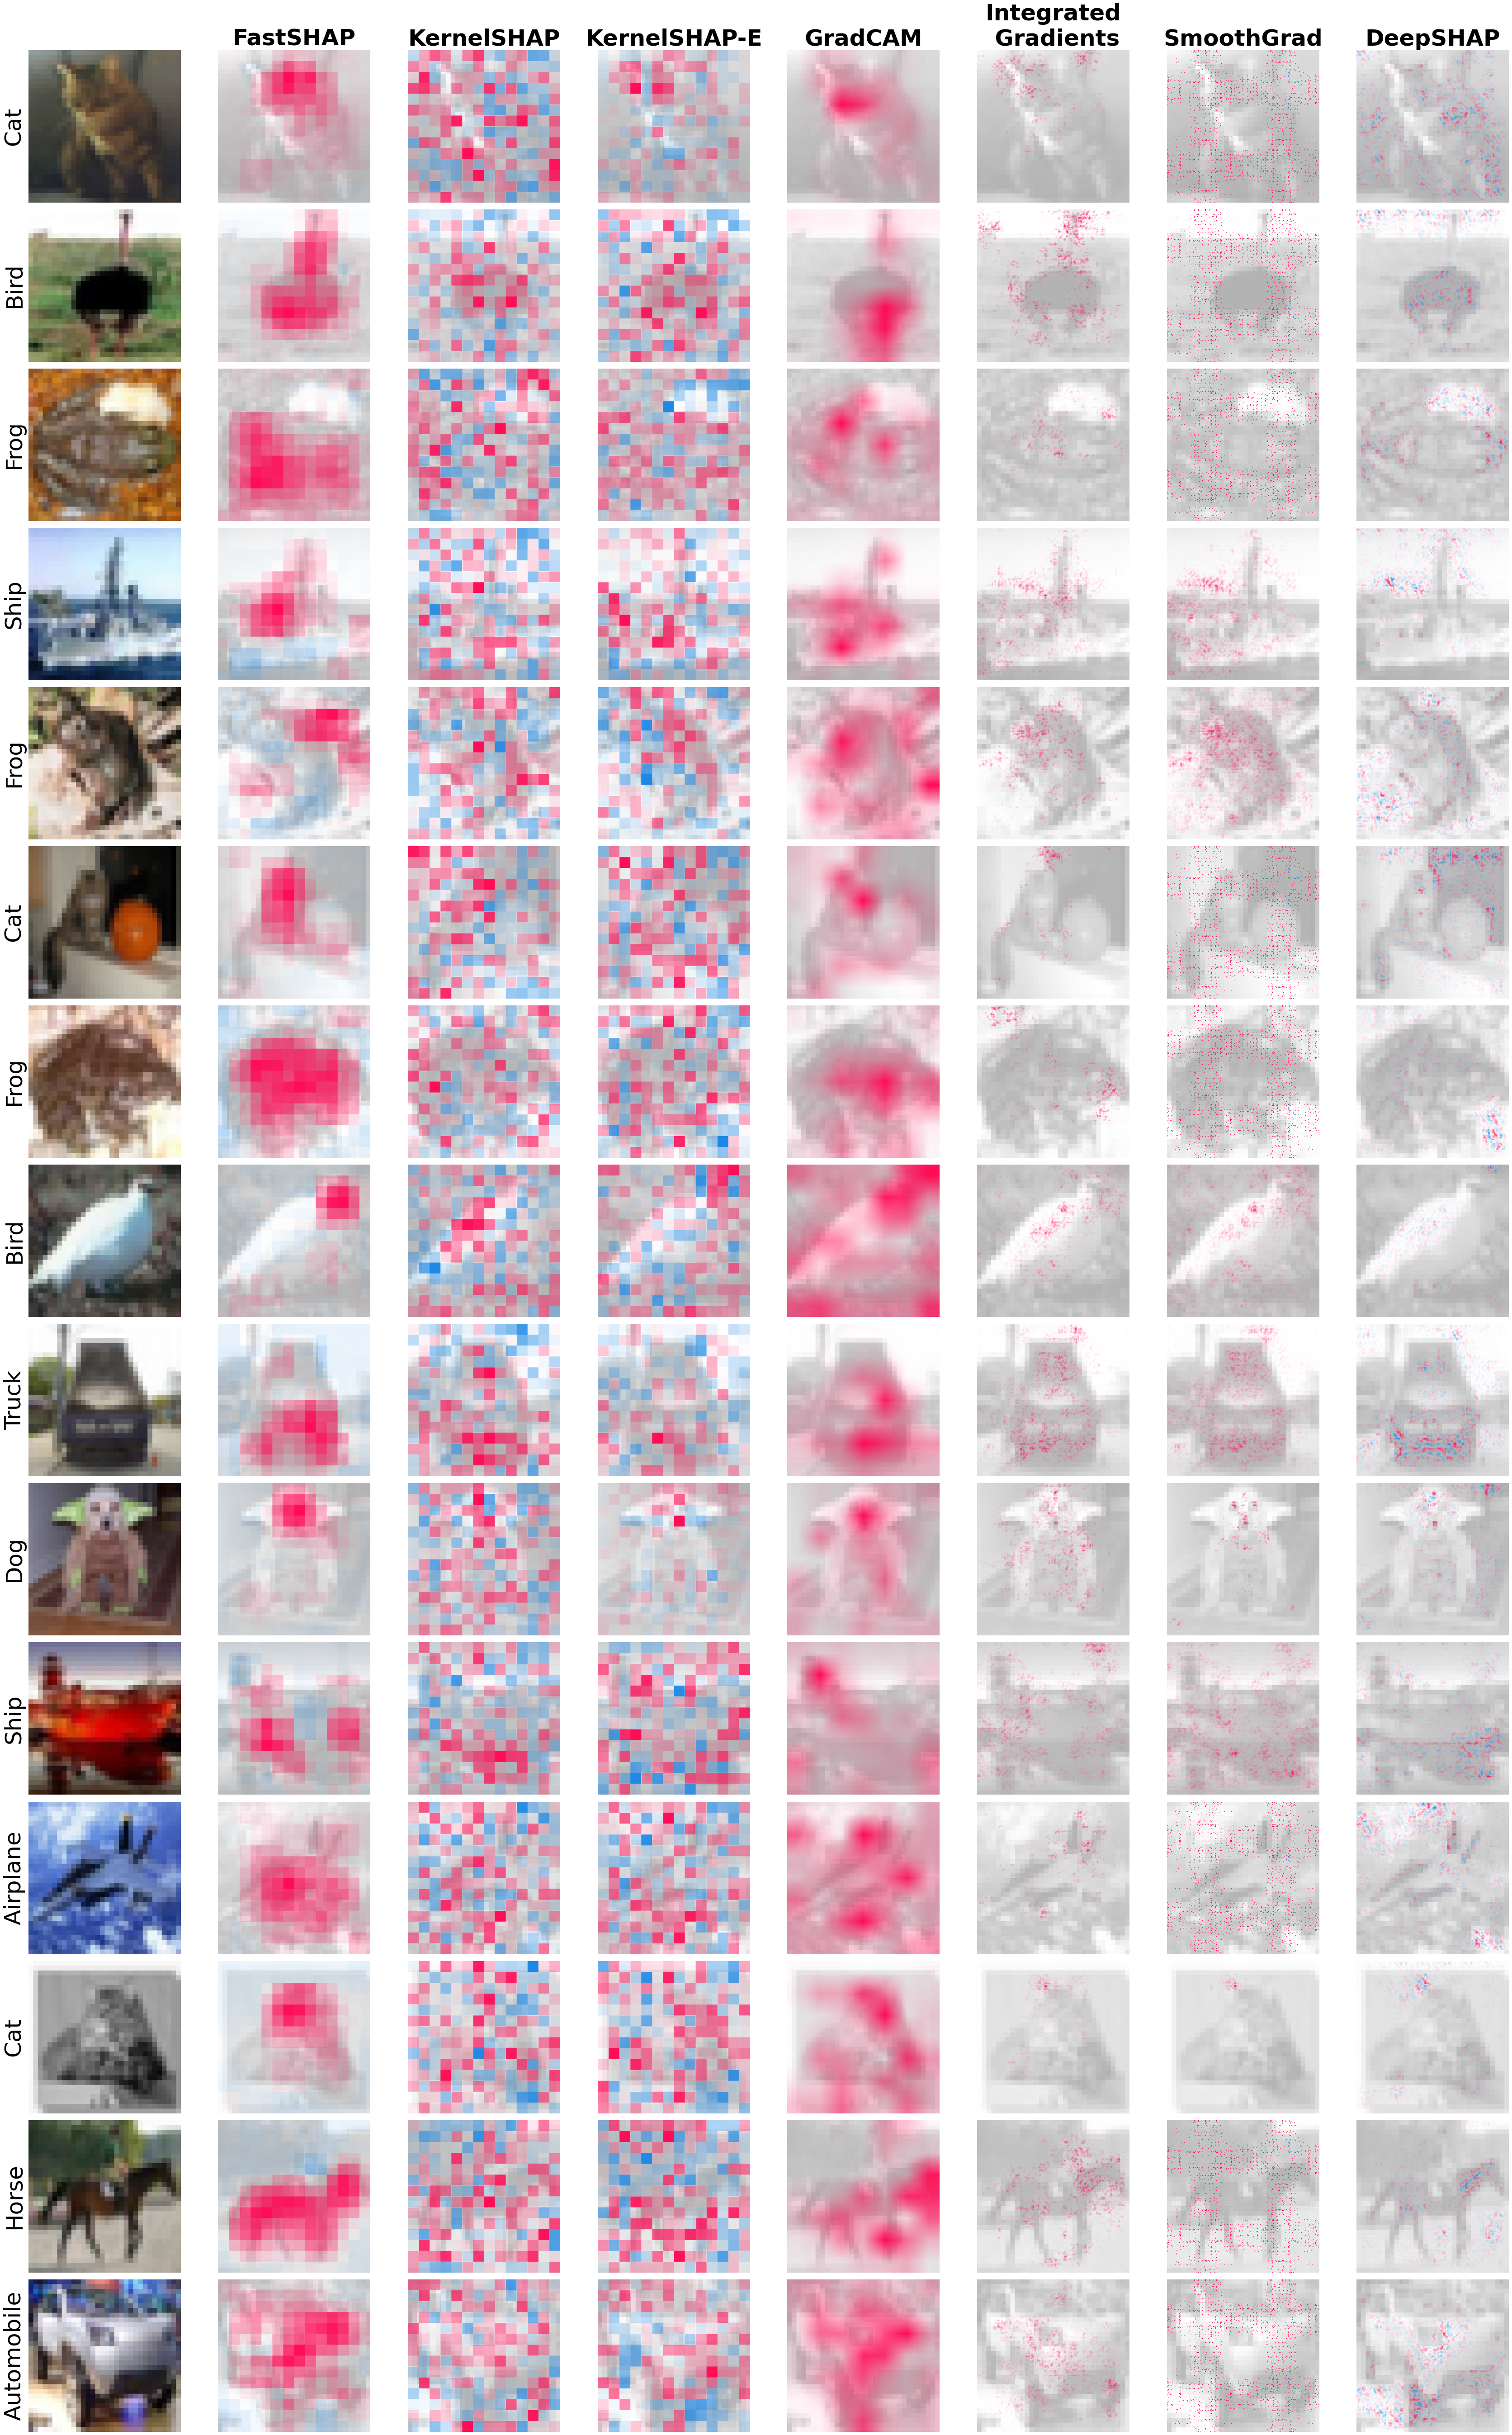

In [11]:
### Plot
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
method_names = ['FastSHAP', 'KernelSHAP', 'KernelSHAP-E', 
                'GradCAM', 'Integrated\n Gradients', 'SmoothGrad', 'DeepSHAP']
fig_size = np.array([6 * (len(explanation_dict.keys()) + 1), 5 * len(images)])
fig, axes = plt.subplots(nrows=len(images), 
                         ncols=len(explanation_dict.keys()) + 1, 
                         figsize=fig_size)
for row in range(len(images)):
    im = images[row]
    
    # get a grayscale version of the image
    if im.max() > 1:
        im /= 255.
    if len(im.shape) == 3 and im.shape[2] == 3:
        im_gray = (0.2989 * im[:,:,0] + 0.5870 * im[:,:,1] + 0.1140 * im[:,:,2]) # rgb to gray
        im_disp = im
    elif len(im.shape) == 3:
        im_gray = im.mean(2)
        # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
        flat_vals = im.reshape([im.shape[0]*im.shape[1], im.shape[2]]).T
        flat_vals = (flat_vals.T - flat_vals.mean(1)).T
        means = kmeans(flat_vals, 3, round_values=False).data.T.reshape([im.shape[0], im.shape[1], 3])
        im_disp = (means - np.percentile(means, 0.5, (0,1))) / (np.percentile(means, 99.5, (0,1)) - np.percentile(means, 1, (0,1)))
        im_disp[im_disp > 1] = 1
        im_disp[im_disp < 0] = 0
    else:
        im_gray = im
        im_disp = im
        
    axes[row,0].imshow(im_disp, cmap=plt.get_cmap('gray'))
    axes[row,0].set_yticklabels([])
    axes[row,0].set_xticklabels([])
    axes[row,0].set_frame_on(False)
    axes[row,0].tick_params(length=0)
    # Class Name
    axes[row,0].set_ylabel('{}'.format(class_names[labels[row].argmax()]), fontsize=50)
    
    for i, (method, name) in enumerate(zip(methods, method_names)):
        ex = explanation_dict[method][row]
        
        #Get Max Val for color range
        abs_vals = np.abs(ex).flatten()
        max_val = np.max(abs_vals)
        if max_val == 0:
            max_val += 1e-8
        
        # Title
        if row == 0:
            axes[row,i+1].set_title(name, fontsize=50)
        
        #Plot
        axes[row,i+1].imshow(im_gray, cmap=plt.get_cmap('gray'), alpha=0.3, extent=(-1, ex.shape[1], ex.shape[0], -1))
        im = axes[row,i+1].imshow(ex, cmap=shap.plots.colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
        axes[row,i+1].axis('off')
        
#Figure args
fig.tight_layout()
plt.savefig(os.path.join('results', 'cifar10_explanations.pdf'))
plt.show()